# Torch vs. ONNX

Verify that the spike detection model output of braindance vs. torch vs. onnx in python is concordant


In [8]:
import json
import numpy as np
import torch
import matplotlib.pyplot as plt

## Load Trained Model


In [9]:
# Instantiate a trained model
from braindance.core.spikedetector.model import ModelSpikeSorter

# detection_model = ModelSpikeSorter.load("checkpoints/spikedetector/mea")

with open("checkpoints/spikedetector/mea/init_dict.json", "r") as f:
    init_dict = json.load(f)
pytorch_model = ModelSpikeSorter(**init_dict)
state_dict = torch.load(
    "checkpoints/spikedetector/mea/state_dict.pt", map_location="cpu"
)
pytorch_model.load_state_dict(state_dict)

<All keys matched successfully>

## Run via Braindance

Populates data/inter if debug=False

```
Saving traces:
100%|██████████| 1/1 [00:04<00:00,  4.46s/it]
Running detection model:
Compiling detection model for 942 elecs ...
Cannot compile detection model with torch_tensorrt because cannot load torch_tensorrt. Skipping NVIDIA compilation
Allocating disk space to save model traces and outputs ...
Inference scaling: 0.3761194029850746
Running model ...
100%|██████████| 832/832 [09:36<00:00,  1.44it/s]
Detecting sequences
100%|██████████| 942/942 [00:04<00:00, 211.68it/s]
Detected 10 preliminary propagation sequences
Extracting sequences' detections, intervals, and amplitudes

100%|██████████| 10/10 [00:02<00:00,  4.03it/s]
8 clusters remain after filtering
Reassigning spikes to preliminary propagation sequences
Initializing ...
Sorting recording
100%|██████████| 1000/1000 [00:00<00:00, 3377.24it/s]
Extracting sequences' detections, intervals, and amplitudes

100%|██████████| 7/7 [00:02<00:00,  2.80it/s]
7 clusters remain after filtering
Merging preliminary propagation sequences - first round

100%|██████████| 7/7 [00:02<00:00,  3.14it/s]
7 sequences after first merging
Merging preliminary propagation sequences - second round ...

RT-Sort detected 7 sequences
```


In [10]:
from braindance.core.spikesorter.rt_sort import detect_sequences

# Detect sequences in the first 5 minutes of a recording
rt_sort = detect_sequences(
    "data/MEA_rec_patch_ground_truth_cell7.raw.h5",
    "data/inter",
    pytorch_model,
    recording_window_ms=(0, 5 * 1000),
    device="cpu",
    verbose=True,
    debug=True,
    # num_processes=1,  # Uncomment for debugging
)

Skipping saving scaled traces because file scaled_traces.npy already exists and debug=True
Skipping running detection model because file model_outputs.npy already exists and debug=True
Skipping detecting preliminary propagation sequences because file all_clusters.pickle already exists and debug=True
Skipping reassigning spikes because file all_clusters_reassigned.pickle already exists and debug=True
Merging preliminary propagation sequences - first round


100%|██████████| 7/7 [00:02<00:00,  2.80it/s]


7 sequences after first merging
Merging preliminary propagation sequences - second round ...

RT-Sort detected 7 sequences


In [11]:
# Load outputs for comparison below
scaled_traces = np.load("data/inter/scaled_traces.npy")
braindance_model_outputs = np.load("data/inter/model_outputs.npy")

## Run via PyTorch

Run using PyTorch with a simplified version of the code in braindance rtsort run_detection_model


In [12]:
import torch
import numpy as np
from tqdm import tqdm


def run_detection_model(
    scaled_traces,
    model,
    inference_scaling_numerator=12.6,
    pre_median_frames=1000,
    device="cpu",
):
    """
    Simplified function to run a PyTorch detection model on scaled traces using windowed computation.

    Parameters:
        scaled_traces (np.ndarray): Input data array of shape (num_channels, recording_duration).
        model: Pre-instantiated PyTorch model with attributes sample_size, num_output_locs, input_scale.
        inference_scaling_numerator (float): Numerator for scaling factor calculation.
        pre_median_frames (int): Number of frames for initial median calculation.
        device (str): Device to run the model on ("cuda" or "cpu").

    Returns:
        torch.Tensor: Model outputs of shape (num_channels, processed_duration).
    """
    # Convert input to torch tensor
    scaled_traces = torch.tensor(scaled_traces, device=device, dtype=torch.float16)

    # Get model parameters
    sample_size = model.sample_size
    num_output_locs = model.num_output_locs
    input_scale = model.input_scale
    num_chans, rec_duration = scaled_traces.shape

    # Calculate inference scaling based on initial window
    window = (
        scaled_traces[:, :pre_median_frames].to(torch.float32).cpu()
    )  # Cast to float32 and move to CPU
    if window.dtype != torch.float32:
        raise ValueError(
            f"Window tensor dtype is {window.dtype}, expected torch.float32"
        )
    iqrs = torch.quantile(window, 0.75, dim=1) - torch.quantile(window, 0.25, dim=1)
    median_iqr = torch.median(iqrs)
    inference_scaling = (
        inference_scaling_numerator / median_iqr if median_iqr != 0 else 1
    )

    # Define windows for processing
    all_start_frames = list(range(0, rec_duration - sample_size + 1, num_output_locs))[
        0:10
    ]
    output_duration = rec_duration - sample_size + 1
    outputs_all = torch.zeros(
        (num_chans, output_duration), device=device, dtype=torch.float16
    )

    # Process each window
    with torch.no_grad():
        for start_frame in tqdm(all_start_frames):
            # Extract window
            traces_torch = scaled_traces[:, start_frame : start_frame + sample_size]

            # Subtract median for baseline correction
            traces_torch = (
                traces_torch - torch.median(traces_torch, dim=1, keepdim=True).values
            )

            # Run model on window and store output
            outputs = model.model(
                traces_torch[:, None, :] * input_scale * inference_scaling
            )
            outputs_all[:, start_frame : start_frame + num_output_locs] = outputs

    return outputs_all.cpu()


pytorch_model_outputs = run_detection_model(
    scaled_traces=scaled_traces, model=pytorch_model, device="cpu"
)

100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


## Compare Braindance to PyTorch Model Outputs


In [13]:
# We only did 10 frames above, so we can check the first 10 frames
end = 10 * pytorch_model.num_output_locs
np.isclose(
    braindance_model_outputs[:, 0:end],
    pytorch_model_outputs.detach().numpy()[:, 0:end],
    rtol=1e-6,
).all()

np.True_

# Export to .onnx


In [14]:
import onnx

pytorch_model.model.eval()  # Set model to evaluation mode

# Convert all parameters to float32
# model = pytorch_model.model.float()  # This casts all parameters to torch.float32

torch.onnx.export(
    pytorch_model.model,
    torch.zeros(1, 1, pytorch_model.sample_size, dtype=torch.float16),
    str("public/models/detect-mea.onnx"),
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={
        "input": {0: "batch_size", 2: "sequence_length"},
        "output": {0: "batch_size", 2: "sequence_length"},
    },
    opset_version=12,
    verbose=False,
)

## Run via PyTorch and ONNX


In [17]:
import torch
import numpy as np
from tqdm import tqdm
import onnxruntime


def run_detection_model_onnx(
    scaled_traces,
    model,
    ort_session,
    inference_scaling_numerator=12.6,
    pre_median_frames=1000,
    device="cpu",
):
    """
    Simplified function to run a PyTorch detection model on scaled traces using windowed computation.

    Parameters:
        scaled_traces (np.ndarray): Input data array of shape (num_channels, recording_duration).
        model: Pre-instantiated PyTorch model with attributes sample_size, num_output_locs, input_scale.
        inference_scaling_numerator (float): Numerator for scaling factor calculation.
        pre_median_frames (int): Number of frames for initial median calculation.
        device (str): Device to run the model on ("cuda" or "cpu").

    Returns:
        torch.Tensor: Model outputs of shape (num_channels, processed_duration).
    """
    # Convert input to torch tensor
    scaled_traces = torch.tensor(scaled_traces, device=device, dtype=torch.float16)

    # Get model parameters
    sample_size = model.sample_size
    num_output_locs = model.num_output_locs
    input_scale = model.input_scale
    num_chans, rec_duration = scaled_traces.shape

    # Calculate inference scaling based on initial window
    window = (
        scaled_traces[:, :pre_median_frames].to(torch.float32).cpu()
    )  # Cast to float32 and move to CPU
    if window.dtype != torch.float32:
        raise ValueError(
            f"Window tensor dtype is {window.dtype}, expected torch.float32"
        )
    iqrs = torch.quantile(window, 0.75, dim=1) - torch.quantile(window, 0.25, dim=1)
    median_iqr = torch.median(iqrs)
    inference_scaling = (
        inference_scaling_numerator / median_iqr if median_iqr != 0 else 1
    )

    # Define windows for processing
    all_start_frames = list(range(0, rec_duration - sample_size + 1, num_output_locs))[
        0:10
    ]
    output_duration = rec_duration - sample_size + 1
    outputs_all = np.zeros((num_chans, output_duration), dtype=np.float16)

    # Process each window
    with torch.no_grad():
        for start_frame in tqdm(all_start_frames):
            # Extract window
            traces_torch = scaled_traces[:, start_frame : start_frame + sample_size]

            # Subtract median for baseline correction
            traces_torch = (
                traces_torch - torch.median(traces_torch, dim=1, keepdim=True).values
            )

            # Run model on window and store output
            input_frame = traces_torch[:, None, :] * input_scale * inference_scaling

            pytorch_outputs = model.model(input_frame)
            onnx_outputs = ort_session.run(
                ["output"],
                {"input": input_frame.numpy()},
            )[0]

            match = np.isclose(
                pytorch_outputs.detach().numpy(),
                onnx_outputs,
                rtol=1e-2,
            ).all()
            assert match, "PyTorch and ONNX outputs do not match!"

            outputs_all[:, start_frame : start_frame + num_output_locs] = (
                onnx_outputs.squeeze()
            )

    return outputs_all


ort_session = onnxruntime.InferenceSession("public/models/detect-mea.onnx")

onnx_model_outputs = run_detection_model_onnx(
    scaled_traces=scaled_traces,
    model=pytorch_model,
    ort_session=ort_session,
    device="cpu",
)

100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


In [10]:
# We only did 20 frames above, so we can check the first 20 frames
end = 10 * pytorch_model.num_output_locs
np.isclose(
    braindance_model_outputs[:, 0:end],
    onnx_model_outputs[:, 0:end],
    rtol=1e-2,
).all()

np.True_

## Find Spikes

Plot the traces and find spikes via threshold


In [11]:
# Scale one channel as it would be presented to the model
pre_median_frames = 1000
inference_scaling_numerator = 12.6

# Calculate inference scaling based on initial window
window = torch.tensor(scaled_traces[:, :pre_median_frames], dtype=torch.float32)
iqrs = torch.quantile(window, 0.75, dim=1) - torch.quantile(window, 0.25, dim=1)
median_iqr = torch.median(iqrs)
inference_scaling = inference_scaling_numerator / median_iqr if median_iqr != 0 else 1

traces_torch = torch.tensor(
    scaled_traces[0, :], dtype=torch.float16
)  # Add channel dimension
traces_torch = (
    (traces_torch - torch.median(traces_torch))
    * pytorch_model.input_scale
    * inference_scaling
)

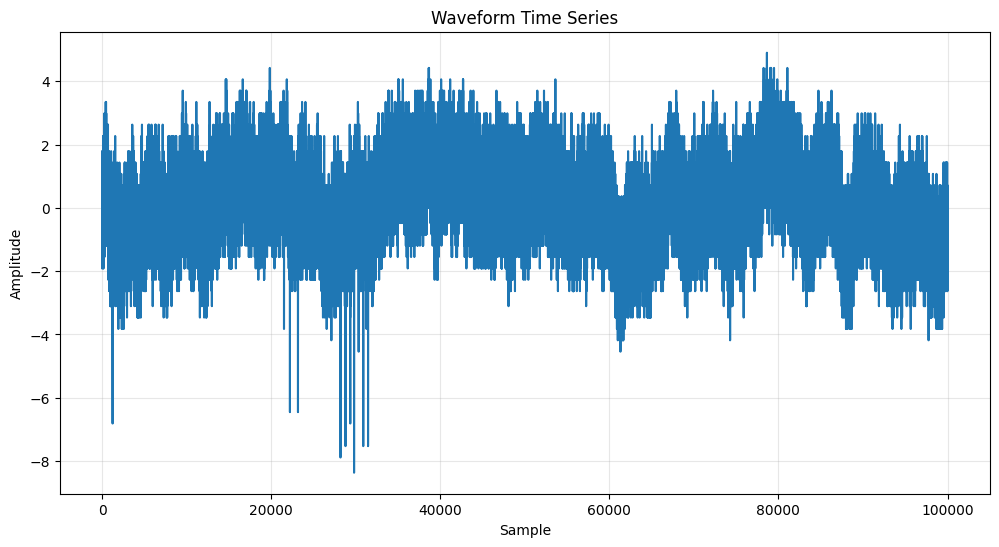

In [12]:
import matplotlib.pyplot as plt


# Plot the waveform as a time series
plt.figure(figsize=(12, 6))
time_points = np.arange(len(traces_torch))
plt.plot(time_points, traces_torch)
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.title("Waveform Time Series")
plt.grid(True, alpha=0.3)
plt.show()

In [13]:
# Find spikes (values below -30) in model_input
waveform_data = traces_torch.numpy()  # Convert to numpy array for processing

# Handle both single and multi-channel cases
if len(waveform_data.shape) == 2:
    num_channels, sequence_length = waveform_data.shape

    spike_locations = []
    for channel in range(num_channels):
        # Find sample indices where values go below -30
        spike_samples = np.where(waveform_data[channel] < -6)[0]

        if len(spike_samples) > 0:
            print(
                f"Channel {channel}: {len(spike_samples)} spikes at samples {spike_samples}"
            )
            # Store channel and sample pairs
            for sample in spike_samples:
                spike_locations.append(
                    (channel, sample, waveform_data[channel, sample])
                )
        # else:
        #     print(f"Channel {channel}: No spikes detected")

    # Summary of all spikes
    print(f"\nTotal spikes found: {len(spike_locations)}")
    if spike_locations:
        print("(Channel, Sample, Value):")
        for channel, sample, value in spike_locations:
            print(f"  ({channel}, {sample}, {value:.2f})")

else:
    # Single channel case
    spike_samples = np.where(waveform_data < -6)[0]
    print(f"Single channel: {len(spike_samples)} spikes at samples {spike_samples}")
    if len(spike_samples) > 0:
        for sample in spike_samples:
            print(f"  Sample {sample}: {waveform_data[sample]:.2f}")

Single channel: 10 spikes at samples [ 1246  1247 22222 23174 28201 28794 29360 29809 30895 31462]
  Sample 1246: -6.09
  Sample 1247: -6.81
  Sample 22222: -6.45
  Sample 23174: -6.45
  Sample 28201: -7.89
  Sample 28794: -7.53
  Sample 29360: -6.81
  Sample 29809: -8.37
  Sample 30895: -7.53
  Sample 31462: -7.53


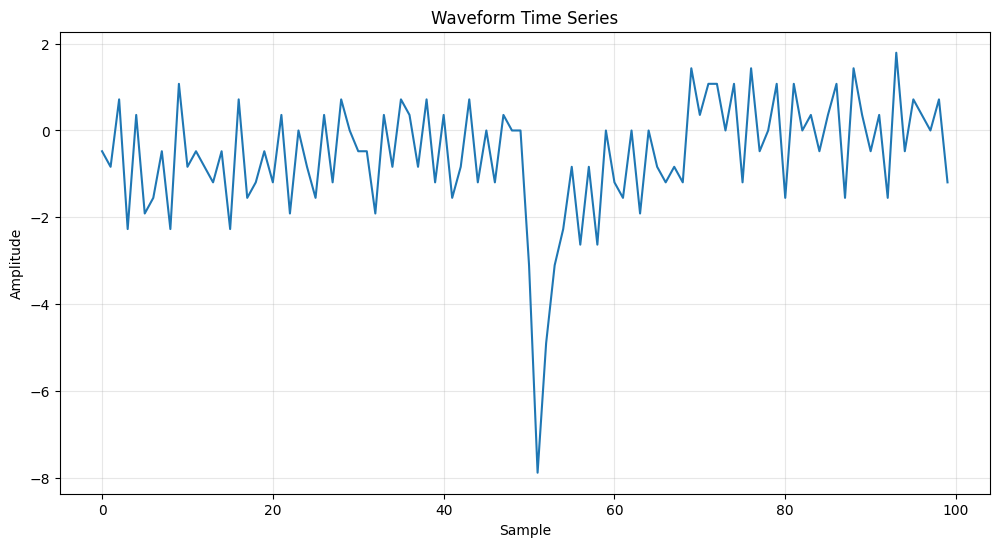

In [14]:
# channel_num = 281
# start_frame = 2725
# test_input = model_input[
#     channel_num : channel_num + 1,
#     :,
#     start_frame : start_frame + pytorch_model.sample_size,
# ]

test_input = traces_torch[28150:28250]

# Plot the waveform as a time series
plt.figure(figsize=(12, 6))
waveform_data = test_input
time_points = np.arange(len(waveform_data))
plt.plot(time_points, waveform_data)
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.title("Waveform Time Series")
plt.grid(True, alpha=0.3)
plt.show()